## Import

In [1]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from ngboost import NGBClassifier
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score

In [2]:
import pandas as pd
import numpy as np
import warnings
import pickle

warnings.filterwarnings(action='default')

## Load

In [4]:
out_data_path = 'C:\\Users\\PC0\\Documents\\datasets\\stock_price\\'
data_path = 'C:\\Users\\PC0\\Documents\\GitHub\\Stock-price-prediction\\datasets\\'

In [5]:
stock_df = pd.read_csv(data_path + "stock_df_01.csv")

In [6]:
n_target = np.array(list(stock_df.target))
c_target = np.array(list(stock_df.c_target))

In [7]:
del stock_df['target']
del stock_df['c_target']

In [8]:
stock_df.shape

(2410, 372)

In [8]:
var_cols = [x for x in stock_df.columns if "var" in x]

In [9]:
stock_df.head()

,date,kosdaq_close,kosdaq_vol,kosdaq_var,us-30_close,us-30_vol,us-30_var,us-spx-500_close,us-spx-500_var,nasdaq-composite_close,...,영국_아연_close,영국_아연_vol,영국_아연_var,은_close,은_vol,은_var,영국_주석_close,영국_주석_var,미국_팔라듐_close,미국_팔라듐_var
0,2012-01-03,513.83,590990.0,1.39,12397.38,152560000.0,1.47,1277.06,1.55,2648.72,...,1864.25,9410.0,1.83,29.533,140.0,4.88,19949.0,4.13,664.8,1.42
1,2012-01-04,516.30,652090.0,0.48,12418.42,145130000.0,0.17,1277.30,0.02,2648.36,...,1856.50,8430.0,-0.42,29.063,70.0,-1.59,19555.0,-1.98,649.9,-2.24
2,2012-01-05,521.96,654300.0,1.10,12415.70,158440000.0,-0.02,1281.06,0.29,2669.86,...,1821.25,7720.0,-1.90,29.265,30.0,0.70,19814.0,1.32,640.4,-1.46
3,2012-01-06,518.94,626020.0,-0.58,12359.92,131120000.0,-0.45,1277.81,-0.25,2674.22,...,1840.75,7120.0,1.07,28.653,80.0,-2.09,19807.0,-0.04,616.1,-3.79
4,2012-01-09,520.28,617370.0,0.26,12392.69,122200000.0,0.27,1280.70,0.23,2676.56,...,1870.25,9620.0,1.60,28.749,60.0,-0.34,19746.0,-0.31,620.0,0.63


## Modeling

* label portion 탐색

In [11]:
Counter(c_target)

Counter({'Down': 1136, 'Up': 1274})

In [12]:
1274/(1136+1274)

0.5286307053941909

In [16]:
temp_x = stock_df.iloc[:, 1:]

* baseline modeling - stacked sample

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
train_volum = 100
train_start_idx = 0
sample_days = 5

data = temp_x

model_xgb = XGBClassifier()
model_lgbm = LGBMClassifier()
model_ngb = NGBClassifier()
model_cat = CatBoostClassifier(verbose = False)

model = model_lgbm

In [19]:
pred_dict = {}

In [20]:
beta = 0.999

In [ ]:
# class imbalance 고려 해야함

In [21]:
train_end_idx = train_start_idx + train_volum
test_start_idx = train_end_idx + 1

whole_predict = []
whole_proba = []
whole_truth = []
whole_acc = []

print("Start Fitting..")
for _ in tqdm(range(data.shape[0] - (train_volum + 1))) :
    temp_train_x = data.loc[:train_end_idx,:]
    temp_train_y = c_target_num.loc[:train_end_idx]
    temp_test_x = data.loc[test_start_idx:test_start_idx,:]
    temp_test_y = c_target_num.loc[test_start_idx]

    # append sample
    temp_train_x = temp_train_x.append(temp_train_x.loc[(train_end_idx - sample_days):])
    temp_train_y = temp_train_y.append(temp_train_y.loc[(train_end_idx - sample_days):])
    
    #sim_mat = cosine_similarity(np.array(temp_train_x))
    
    sample_w = [beta ** x for x in range((temp_train_x.shape[0]), 0, -1)]
    sample_w = np.array(sample_w) + 1-np.mean(sample_w)
    
    # fitting
    model.fit(temp_train_x,temp_train_y, sample_weight=sample_w)
    #model.fit(temp_train_x,temp_train_y, sample_weight=sim_mat[-1])
    #model.fit(temp_train_x,temp_train_y)
    
    # predict
    predict_value = model.predict(temp_test_x)
    whole_proba.append(model.predict_proba(temp_test_x)[0])

    # save acc
    pred_dict[stock_df.date[test_start_idx]] = predict_value[0]
    whole_predict.append(predict_value[0])
    whole_truth.append(temp_test_y.iloc[0])

    train_start_idx += 1
    train_end_idx = train_start_idx + train_volum
    test_start_idx = train_end_idx + 1

print("Finish")

  0%|                                                                                         | 0/2309 [00:00<?, ?it/s]C:\Users\PC0\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  0%|                                                                                 | 1/2309 [00:00<04:35,  8.38it/s]

Start Fitting..


100%|██████████████████████████████████████████████████████████████████████████████| 2309/2309 [33:09<00:00,  1.16it/s]

Finish


* lightgbm performance - with sample weights 0.999 beta adjust

In [22]:
accuracy_score(whole_truth, whole_predict)

0.6145517540060632

In [23]:
precision_score(whole_truth, whole_predict)

0.6258555133079848

In [24]:
recall_score(whole_truth, whole_predict)

0.674037674037674

In [25]:
f1_score(whole_truth, whole_predict)

0.6490536277602523

In [26]:
cohen_kappa_score(whole_truth, whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.22288055410804897

In [27]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [28]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.7320754716981133

In [29]:
np.mean(np.array(whole_truth)[one_idx])

0.6857142857142857

## XAI

In [239]:
from lime import lime_tabular

In [242]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(temp_train_x),
    feature_names=temp_train_x.columns,
    class_names=['Down', 'Up'],
    mode='classification'
)

In [259]:
lime_exp = lime_explainer.explain_instance(
    data_row=temp_train_x.iloc[2],
    predict_fn=model.predict_proba
)

C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [354]:
lime_exp.as_list()

[('us-spx-500_var > 0.51', 0.09627362022590456),
 ('us-30_var > 0.49', 0.06143985250882359),
 ('달러/남아프리카_란드_var <= -0.60', 0.054981638687521386),
 ('spain-35_var > 0.68', 0.05430633583327941),
 ('s-p-tsx-composite_var > 0.43', 0.051271170941502194),
 ('달러/스웨덴_크로나_var > 0.37', -0.046299122260462296),
 ('-0.43 < 달러/멕시코_페소_var <= 0.00', 0.04132942702384455),
 ('france-40_var > 0.61', 0.03892185016637705),
 ('france-10_var > 2.55', -0.03769360115152981),
 ('영국_구리_var > 0.71', 0.03635580629301755)]

* 확실한 sample들 lime 돌리기

In [302]:
tr = 0.8
confidence_idx = [idx for idx, x in enumerate(whole_proba) if (x[0] > tr) or (x[1] > tr)]

In [306]:
correct_idx = [confidence_idx[idx] for idx, x in enumerate(confidence_idx) if whole_truth[x] == whole_predict[x]]

In [319]:
incorrect_idx = [confidence_idx[idx] for idx, x in enumerate(confidence_idx) if whole_truth[x] != whole_predict[x]]

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [313]:
correct_idx_d = [x + 100 for x in correct_idx]

In [314]:
correct_df = data.iloc[correct_idx_d,:]

In [321]:
lime_dict = {}

In [ ]:
for idx in tqdm(range(len(correct_idx))):
    lime_exp = lime_explainer.explain_instance(
            data_row=correct_df.iloc[idx],
            predict_fn=model.predict_proba
        )
    lime_dict[str(correct_idx[idx])] = lime_exp

In [329]:
'''with open(data_path + 'lime_dict.pickle', 'wb') as f:
    pickle.dump(lime_dict, f, pickle.HIGHEST_PROTOCOL)'''

In [350]:
# r square of linear model
lime_dict['6'].score

0.12286694083257466

In [334]:
# intercept of linear model
lime_dict['1'].intercept

{1: 0.5372941817163116}

In [394]:
exp_col_idx = [x[0] for x in list(lime_dict['1'].local_exp.values())[0]]

In [396]:
np.array(temp_train_x.columns)[exp_col_idx]

array(['s-p-tsx-composite_var', 'france-40_var', 'dj-shanghai_var',
       'france-10_var', 'hang-sen-40_var', 'shanghai-composite_var',
       'nasdaq-composite_var', 'kosdaq_var', '스위스_프랑/엔_var',
       'japan-ni225_var'], dtype=object)

In [384]:
np.array(temp_train_x.columns)[32]

'france-40_var'

In [326]:
# coefficient of linear model
lime_dict['1'].as_list()

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('s-p-tsx-composite_var <= -0.33', -0.05865994956195112),
 ('0.07 < france-40_var <= 0.61', 0.04625367283653943),
 ('dj-shanghai_var <= -0.54', 0.03687377844053242),
 ('france-10_var > 2.55', -0.03517686679163335),
 ('hang-sen-40_var > 0.64', -0.03302576552274919),
 ('shanghai-composite_var <= -0.51', 0.031803976689793755),
 ('nasdaq-composite_var <= -0.39', -0.030982819132667604),
 ('kosdaq_var > 0.75', -0.030290451103731426),
 ('스위스_프랑/엔_var > 0.30', -0.02936149412475346),
 ('japan-ni225_var > 0.73', -0.028094601982210667)]

In [336]:
# coefficient of linear model
lime_dict['2'].as_list()

[('us-spx-500_var > 0.51', 0.09180711193459476),
 ('france-40_var <= -0.53', -0.076232737711395),
 ('us-30_var > 0.49', 0.05943905694722265),
 ('spain-35_var > 0.68', 0.0555385159558343),
 ('s-p-tsx-composite_var <= -0.33', -0.05541439799358382),
 ('ise-100_var > 0.86', 0.04446082210944168),
 ('nasdaq-composite_var > 0.67', 0.03662137235094501),
 ('kospi-200_var <= -0.48', 0.036076565074351516),
 ('달러/멕시코_페소_var <= -0.43', 0.03579302664741233),
 ('hang-sen-40_var <= -0.60', 0.033964340277893544)]

In [337]:
# coefficient of linear model
lime_dict['3'].as_list()

[('달러/멕시코_페소_var > 0.44', -0.08741605929994485),
 ('us-spx-500_var <= -0.32', -0.08495713513705377),
 ('s-p-tsx-composite_var <= -0.33', -0.04758270337932049),
 ('nasdaq-composite_var <= -0.39', -0.044041933536768746),
 ('us-30_var <= -0.33', -0.04231802405897409),
 ('dj-shanghai_var > 0.66', -0.03344919907534244),
 ('kosdaq_var > 0.75', -0.03207291167936025),
 ('-0.61 < psi-20_var <= 0.02', -0.03180961068020383),
 ('volatility-s-p-500_var > 3.63', -0.030970625608865068),
 ('영국_구리_var > 0.71', 0.025858425344794447)]

In [339]:
# coefficient of linear model
lime_dict['6'].as_list()

[('us-spx-500_var > 0.51', 0.08912768529630515),
 ('us-30_var > 0.49', 0.061544333505648405),
 ('spain-35_var > 0.68', 0.0590807676954259),
 ('ipc_var > 0.56', 0.05054255621254792),
 ('hang-sen-40_var <= -0.60', 0.042739660301203575),
 ('dj-shanghai_var <= -0.54', 0.04059741786158961),
 ('달러/스웨덴_크로나_var <= -0.36', 0.034495950856139),
 ('달러/멕시코_페소_var <= -0.43', 0.03065653939387012),
 ('0.07 < france-40_var <= 0.61', 0.029342618528203832),
 ('달러/인도_루피_var > 0.22', -0.02579785619932995)]

In [356]:
labels = [np.argmax(x) for x in np.array(whole_proba)[confidence_idx]]

In [358]:
[x[0] for x in lime_dict['6'].as_list()]

['us-spx-500_var > 0.51',
 'us-30_var > 0.49',
 'spain-35_var > 0.68',
 'ipc_var > 0.56',
 'hang-sen-40_var <= -0.60',
 'dj-shanghai_var <= -0.54',
 '달러/스웨덴_크로나_var <= -0.36',
 '달러/멕시코_페소_var <= -0.43',
 '0.07 < france-40_var <= 0.61',
 '달러/인도_루피_var > 0.22']

In [359]:
[x[0] for x in lime_dict['1'].as_list()]

['s-p-tsx-composite_var <= -0.33',
 '0.07 < france-40_var <= 0.61',
 'dj-shanghai_var <= -0.54',
 'france-10_var > 2.55',
 'hang-sen-40_var > 0.64',
 'shanghai-composite_var <= -0.51',
 'nasdaq-composite_var <= -0.39',
 'kosdaq_var > 0.75',
 '스위스_프랑/엔_var > 0.30',
 'japan-ni225_var > 0.73']

* 기간별 accuracy

In [131]:
predict_df = pd.DataFrame({"date": stock_df.tail(2309).date, "predict": whole_predict, "truth": whole_truth})

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
# predict_df.to_csv(data_path + "predict_lgbm_adj_999.csv", index = False)

In [75]:
predict_df.head()

,date,predict,truth
101,2012-06-07,1,0
102,2012-06-08,1,1
103,2012-06-11,0,0
104,2012-06-12,1,1
105,2012-06-13,1,1


In [130]:
predict_df.tail(10)

,date,predict,truth
2400,2022-02-17,0,0
2401,2022-02-21,0,0
2402,2022-02-22,1,1
2403,2022-02-23,0,0
2404,2022-02-24,1,1
2405,2022-02-25,1,1
2406,2022-02-28,0,0
2407,2022-03-02,1,1
2408,2022-03-03,0,0
2409,2022-03-04,0,0


* 기간별 performance

In [219]:
# 이 기간이 결측치가 가장 없었나?
start_date = '2022-01-01'
end_date = '2022-03-04'

In [220]:
temp_truth = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].truth
temp_predict = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].predict

In [221]:
print(classification_report(temp_truth, temp_predict, digits = 4))

              precision    recall  f1-score   support

           0     0.8000    0.8696    0.8333        23
           1     0.7857    0.6875    0.7333        16

    accuracy                         0.7949        39
   macro avg     0.7929    0.7785    0.7833        39
weighted avg     0.7941    0.7949    0.7923        39



In [222]:
print(Counter(temp_truth), "\n", Counter(temp_predict))

Counter({0: 23, 1: 16}) 
 Counter({0: 25, 1: 14})


In [223]:
start_date = '2021-10-01'
end_date = '2022-01-01'

In [224]:
temp_truth = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].truth
temp_predict = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].predict

In [225]:
print(classification_report(temp_truth, temp_predict, digits = 4))

              precision    recall  f1-score   support

           0     0.5714    0.5517    0.5614        29
           1     0.5938    0.6129    0.6032        31

    accuracy                         0.5833        60
   macro avg     0.5826    0.5823    0.5823        60
weighted avg     0.5830    0.5833    0.5830        60



In [226]:
print(Counter(temp_truth), "\n", Counter(temp_predict))

Counter({1: 31, 0: 29}) 
 Counter({1: 32, 0: 28})


In [227]:
start_date = '2021-07-01'
end_date = '2021-10-01'

In [228]:
temp_truth = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].truth
temp_predict = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].predict

In [229]:
print(classification_report(temp_truth, temp_predict, digits = 4))

              precision    recall  f1-score   support

           0     0.6786    0.5758    0.6230        33
           1     0.5758    0.6786    0.6230        28

    accuracy                         0.6230        61
   macro avg     0.6272    0.6272    0.6230        61
weighted avg     0.6314    0.6230    0.6230        61



In [230]:
print(Counter(temp_truth), "\n", Counter(temp_predict))

Counter({0: 33, 1: 28}) 
 Counter({1: 33, 0: 28})


In [231]:
start_date = '2021-04-01'
end_date = '2021-07-01'

In [232]:
temp_truth = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].truth
temp_predict = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].predict

In [233]:
print(classification_report(temp_truth, temp_predict, digits = 4))

              precision    recall  f1-score   support

           0     0.4000    0.4000    0.4000        25
           1     0.5588    0.5588    0.5588        34

    accuracy                         0.4915        59
   macro avg     0.4794    0.4794    0.4794        59
weighted avg     0.4915    0.4915    0.4915        59



In [234]:
print(Counter(temp_truth), "\n", Counter(temp_predict))

Counter({1: 34, 0: 25}) 
 Counter({1: 34, 0: 25})


In [235]:
start_date = '2021-01-01'
end_date = '2021-04-01'

In [236]:
temp_truth = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].truth
temp_predict = predict_df.loc[(predict_df.date >= start_date) & (predict_df.date <= end_date)].predict

In [237]:
print(classification_report(temp_truth, temp_predict, digits = 4))

              precision    recall  f1-score   support

           0     0.6364    0.6562    0.6462        32
           1     0.5769    0.5556    0.5660        27

    accuracy                         0.6102        59
   macro avg     0.6066    0.6059    0.6061        59
weighted avg     0.6092    0.6102    0.6095        59



In [238]:
print(Counter(temp_truth), "\n", Counter(temp_predict))

Counter({0: 32, 1: 27}) 
 Counter({0: 33, 1: 26})


* plotting

In [79]:
from copy import deepcopy

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [135]:
plot_df = deepcopy(predict_df)

In [136]:
plot_df.index = plot_df.date

In [137]:
del plot_df['date']

In [81]:
def function_x(idx, vector):
    vector = np.where(np.array(vector) == 0, -1, 1)
    return np.sum(vector[:idx])

In [82]:
predict_2 = [function_x(idx, predict_df.predict) for idx in range(len(predict_df.predict))]
actual_2 = [function_x(idx, predict_df.truth) for idx in range(len(predict_df.predict))]

In [83]:
plot_df['predict_2'] = predict_2
plot_df['actual_2'] = actual_2

In [84]:
del plot_df['predict'], plot_df['truth']

<AxesSubplot:xlabel='date'>

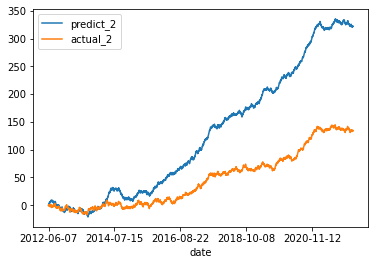

In [85]:
plot_df.plot()

In [86]:
from sklearn.metrics import classification_report

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
print(classification_report(whole_truth, whole_predict))

              precision    recall  f1-score   support

           0       0.60      0.55      0.57      1088
           1       0.63      0.67      0.65      1221

    accuracy                           0.61      2309
   macro avg       0.61      0.61      0.61      2309
weighted avg       0.61      0.61      0.61      2309



In [89]:
Counter(whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({1: 1315, 0: 994})

In [90]:
Counter(whole_truth)

Counter({0: 1088, 1: 1221})

* label별 성능

In [106]:
zero_idx = np.where(np.array(whole_truth) == 0)[0]
one_idx = np.where(np.array(whole_truth) != 0)[0]

In [105]:
1 - np.mean(np.array(whole_predict)[zero_idx])

0.5477941176470589

In [107]:
np.mean(np.array(whole_predict)[one_idx])

0.674037674037674

In [111]:
Counter(whole_truth)

Counter({0: 1088, 1: 1221})

In [208]:
Counter(whole_predict)

Counter({1: 1315, 0: 994})

In [210]:
994/(1315+994)

0.43048938934603725